# Arabic Dialect Classification Using Explainable AI and Semantic Vector Embeddings

This notebook implements a dialect classification system for Arabic text using the MADAR dataset, which contains sentences in 26 different Arabic dialects (including Modern Standard Arabic).

## Project Overview

- **Task**: Classify Arabic sentences according to their local dialect
- **Model**: AraBERT (Arabic BERT)
- **Explainability**: SHAP and LIME for model interpretation
- **Dataset**: MADAR Corpus (Multi-Arabic Dialect Applications and Resources)

## Implementation Steps

1. Data Loading and Exploration
2. Data Preprocessing
3. AraBERT Model Setup
4. Model Training
5. Model Evaluation
6. Model Interpretation with XAI
7. Visualization and Analysis

## 1. Setup and Dependencies

In [ ]:
# Install required packages
!pip install transformers datasets pandas numpy matplotlib seaborn scikit-learn torch lime shap arabert pyarabic farasa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline
import lime
import lime.lime_text
import shap
import re
import random
import os
from tqdm.notebook import tqdm

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## 2. Data Loading and Exploration

In [ ]:
# Load the MADAR dataset
df = pd.read_csv('MADAR_Corpus_Combined.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (112000, 3)


,split,lang,sent
0,corpus-6-dev,TUN,وريني جدول الاوقات، يعيشك.
1,corpus-6-test-corpus-26-train,ASW,معندكش دروس تجريبية؟
2,corpus-6-train,RAB,اه، مزيان.
3,corpus-6-train,DOH,اظن الرقم غلط.
4,corpus-6-train,CAI,مسار الخير، فندق النجمة. أي خدمة؟


In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
split    0
lang     0
sent     0
dtype: int64


Number of unique dialects: 26

Dialect distribution:
lang
TUN    12000
RAB    12000
CAI    12000
DOH    12000
MSA    12000
BEI    12000
BAS     2000
AMM     2000
MOS     2000
ASW     2000
BAG     2000
RIY     2000
SAL     2000
ALE     2000
KHA     2000
SAN     2000
FES     2000
DAM     2000
JER     2000
TRI     2000
JED     2000
SFX     2000
BEN     2000
MUS     2000
ALX     2000
ALG     2000
Name: count, dtype: int64


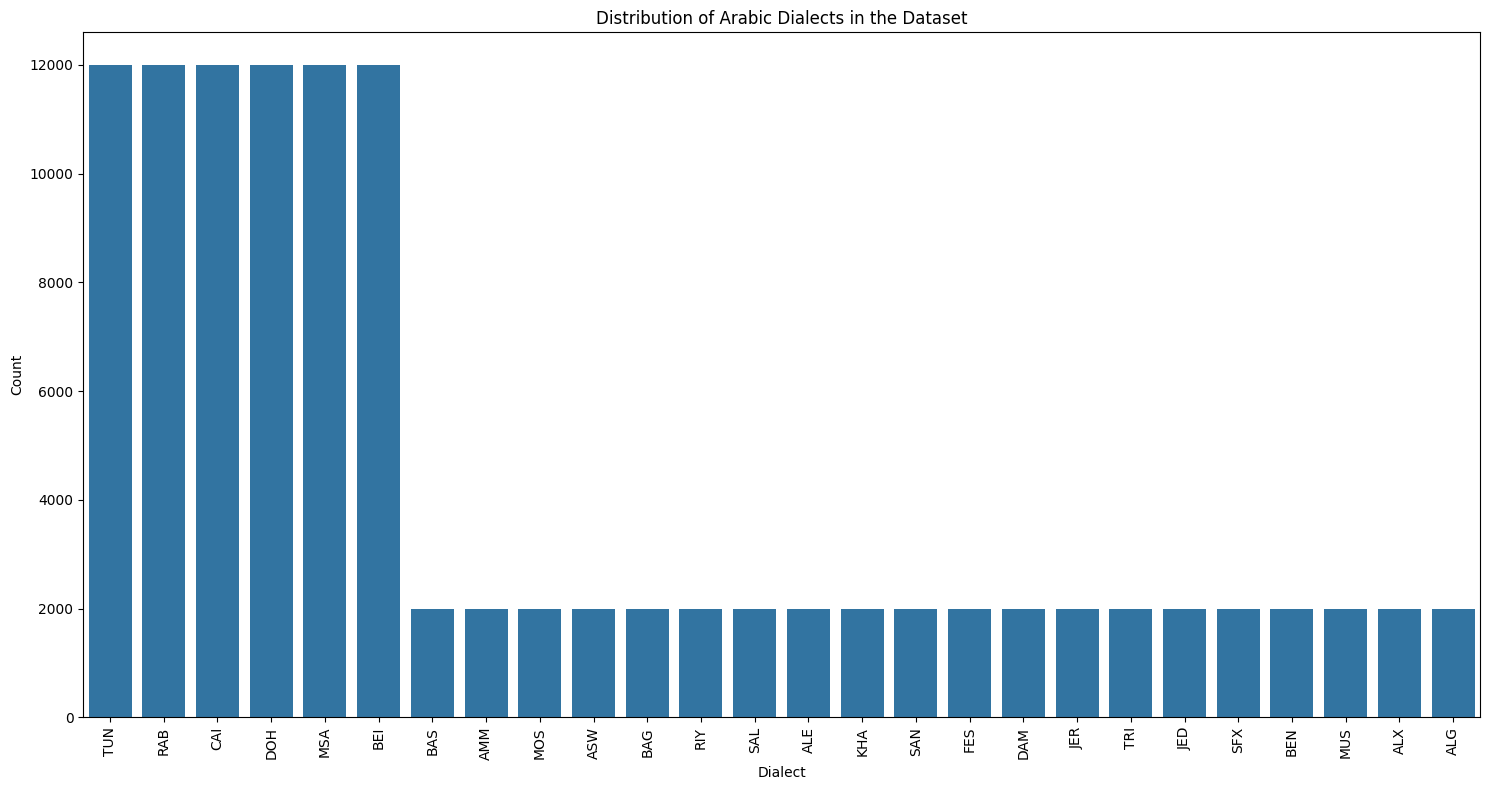

In [ ]:
# Explore the distribution of dialects
dialect_counts = df['lang'].value_counts()
print(f"Number of unique dialects: {len(dialect_counts)}")
print("\nDialect distribution:")
print(dialect_counts)

# Visualize dialect distribution
plt.figure(figsize=(15, 8))
sns.barplot(x=dialect_counts.index, y=dialect_counts.values)
plt.title('Distribution of Arabic Dialects in the Dataset')
plt.xlabel('Dialect')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

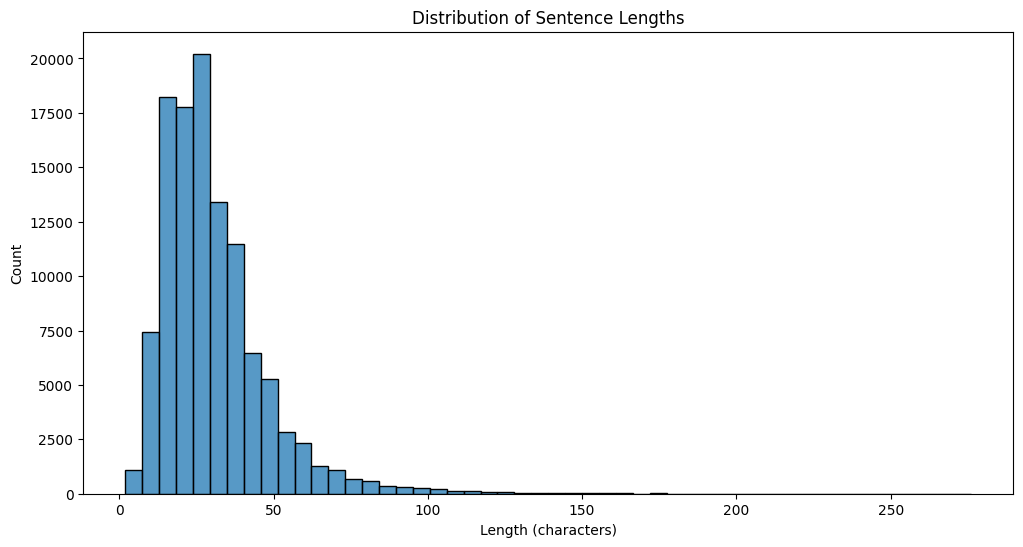

Average sentence length: 30.50 characters
Minimum sentence length: 2 characters
Maximum sentence length: 276 characters


In [ ]:
# Explore sentence lengths
df['sent_length'] = df['sent'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['sent_length'], bins=50)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

print(f"Average sentence length: {df['sent_length'].mean():.2f} characters")
print(f"Minimum sentence length: {df['sent_length'].min()} characters")
print(f"Maximum sentence length: {df['sent_length'].max()} characters")

## 3. Data Preprocessing

In [ ]:
# Create a mapping from dialect labels to numeric indices
dialects = sorted(df['lang'].unique())
dialect_to_id = {dialect: idx for idx, dialect in enumerate(dialects)}
id_to_dialect = {idx: dialect for dialect, idx in dialect_to_id.items()}

# Add numeric labels to the dataframe
df['label'] = df['lang'].map(dialect_to_id)

# Display the mapping
print("Dialect to ID mapping:")
for dialect, idx in dialect_to_id.items():
    print(f"{dialect}: {idx}")

Dialect to ID mapping:
ALE: 0
ALG: 1
ALX: 2
AMM: 3
ASW: 4
BAG: 5
BAS: 6
BEI: 7
BEN: 8
CAI: 9
DAM: 10
DOH: 11
FES: 12
JED: 13
JER: 14
KHA: 15
MOS: 16
MSA: 17
MUS: 18
RAB: 19
RIY: 20
SAL: 21
SAN: 22
SFX: 23
TRI: 24
TUN: 25


In [ ]:
# Split the data into training, validation, and test sets
# First, separate by split column if it exists
if 'split' in df.columns:
    train_df = df[df['split'].str.contains('train')].copy()
    val_df = df[df['split'].str.contains('dev')].copy()
    test_df = df[df['split'].str.contains('test')].copy()

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
else:
    # If no split column, create our own splits
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

Training set size: 95600
Validation set size: 11200
Test set size: 52000


## 4. AraBERT Model Setup

In [ ]:
# Load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv01"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a model with the correct number of labels (dialects)
num_labels = len(dialects)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/780k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv01 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Create a custom dataset class for our Arabic dialect data
class ArabicDialectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text,
                                  truncation=True,
                                  padding='max_length',
                                  max_length=self.max_length,
                                  return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Create datasets
train_dataset = ArabicDialectDataset(train_df['sent'].tolist(), train_df['label'].tolist(), tokenizer)
val_dataset = ArabicDialectDataset(val_df['sent'].tolist(), val_df['label'].tolist(), tokenizer)
test_dataset = ArabicDialectDataset(test_df['sent'].tolist(), test_df['label'].tolist(), tokenizer)

## 5. Model Training

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

In [ ]:
# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mahmoudabdulhamid22 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.026100,1.036826,0.692232


Epoch,Training Loss,Validation Loss,Accuracy
1,1.026100,1.036826,0.692232
2,0.714700,0.889399,0.724643
3,0.540200,0.925918,0.741786


TrainOutput(global_step=17925, training_loss=0.9216158168053195, metrics={'train_runtime': 6709.3962, 'train_samples_per_second': 42.746, 'train_steps_per_second': 2.672, 'total_flos': 1.88691278321664e+16, 'train_loss': 0.9216158168053195, 'epoch': 3.0})

## 6. Model Evaluation

In [ ]:
# Evaluate on the test set
test_results = trainer.evaluate(test_dataset)
print(f"Test accuracy: {test_results['eval_accuracy']:.4f}")

Test accuracy: 0.7243


In [ ]:
# Get predictions for the test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Convert numeric predictions back to dialect labels
pred_dialects = [id_to_dialect[pred] for pred in preds]
true_dialects = [id_to_dialect[label] for label in labels]

# Create a classification report
print("Classification Report:")
print(classification_report(true_dialects, pred_dialects))

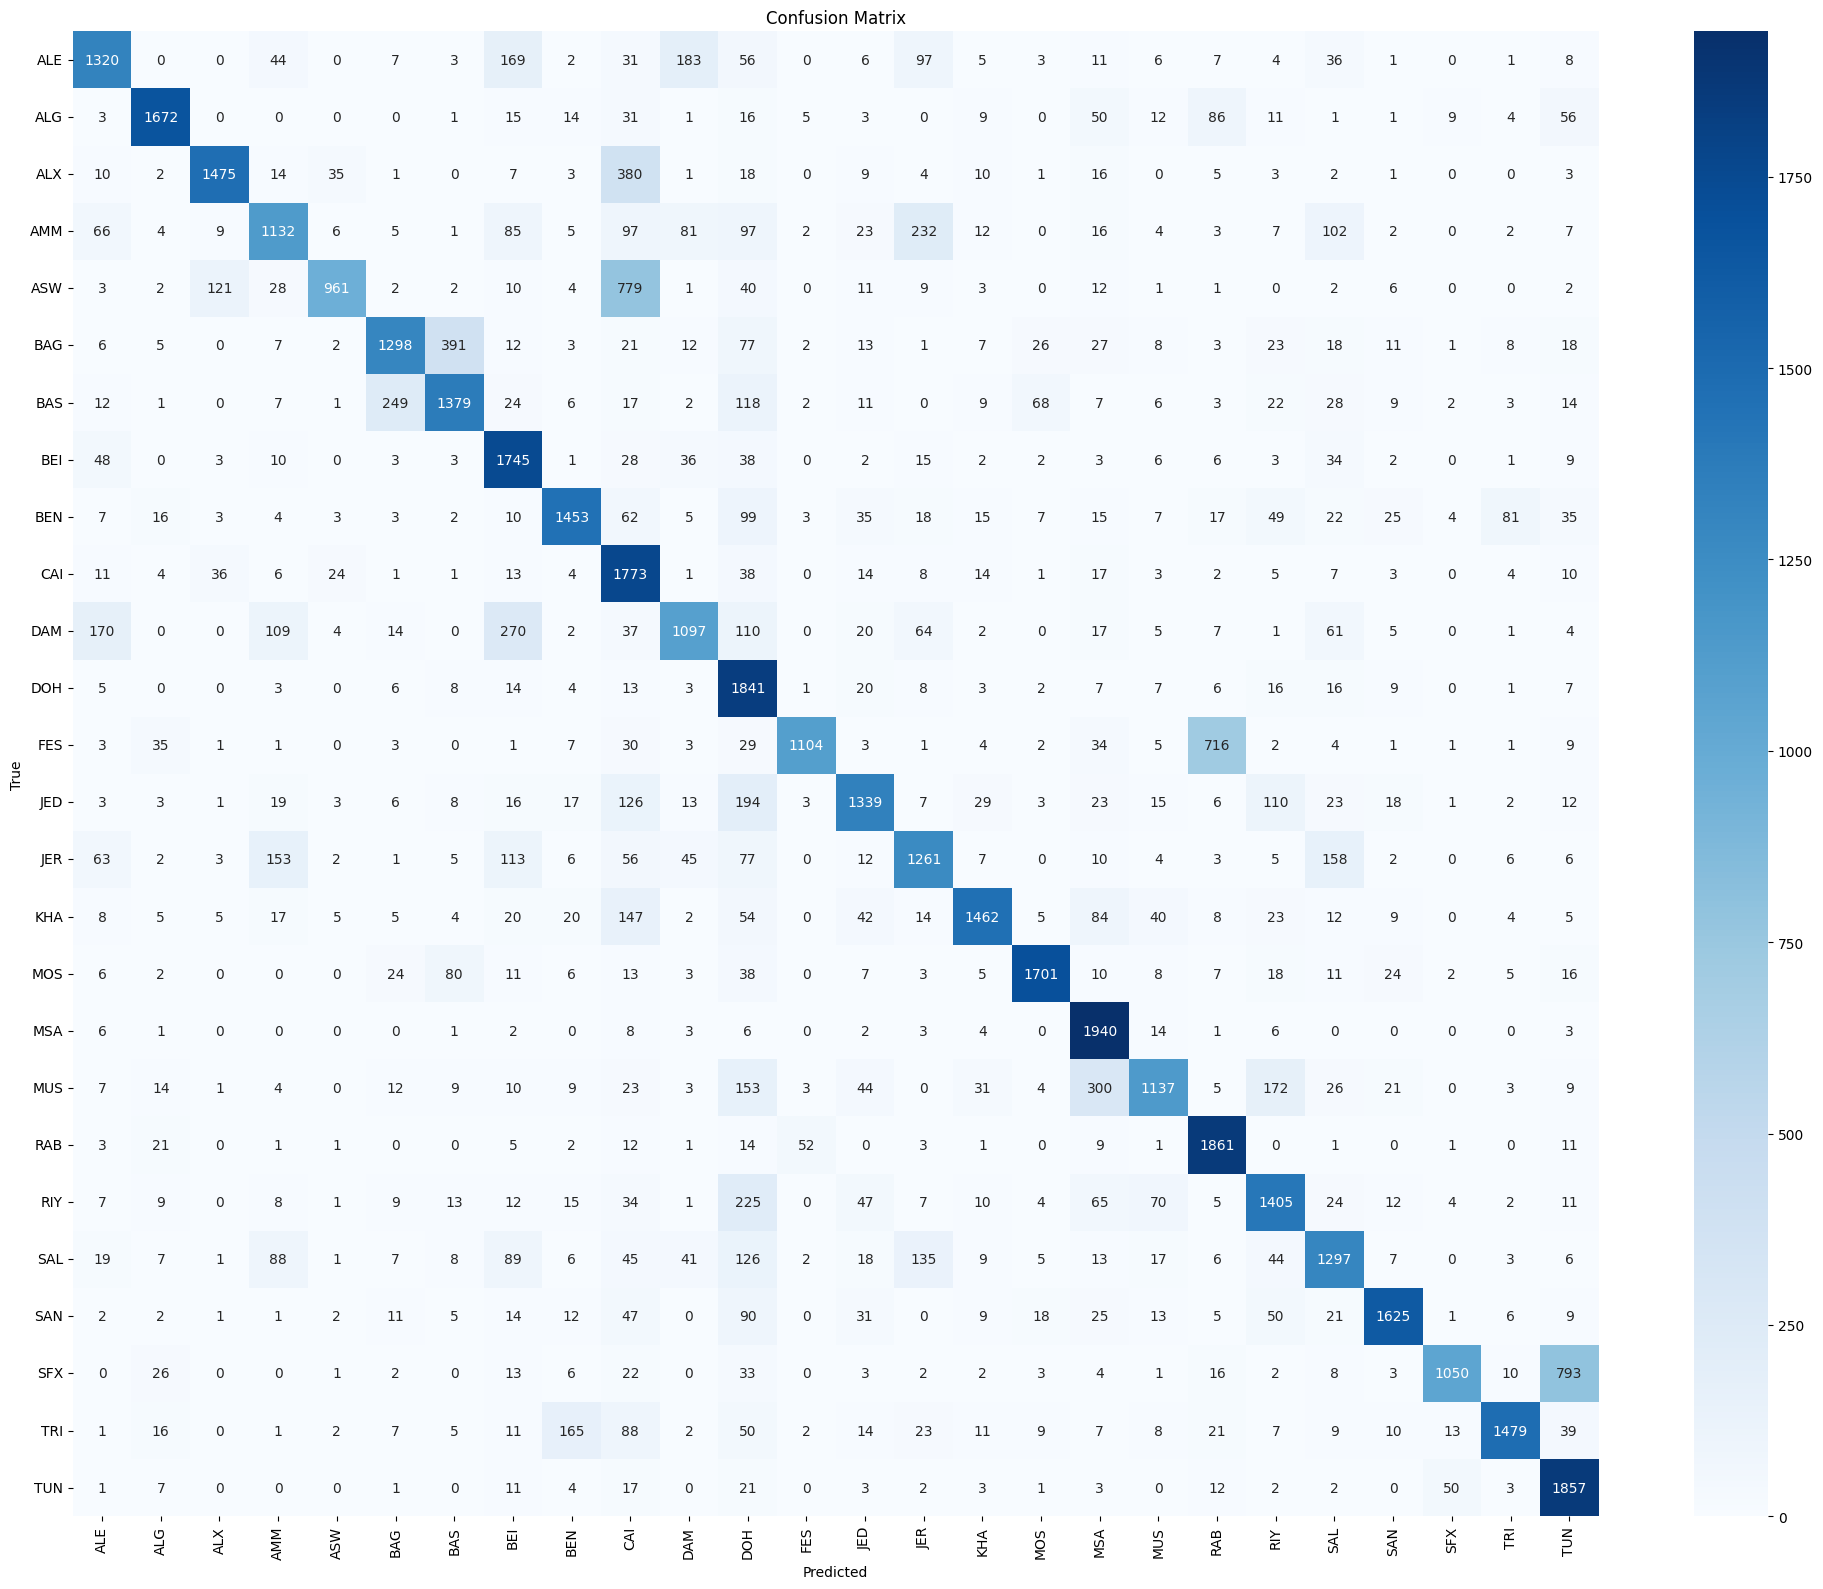

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dialects, yticklabels=dialects)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Model Deployment and Inference

In [ ]:
# Save the trained model and tokenizer
model_save_path = './arabic_dialect_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Save the dialect mappings
import json
with open(f"{model_save_path}/dialect_mappings.json", 'w') as f:
    json.dump({
        'dialect_to_id': dialect_to_id,
        'id_to_dialect': {str(k): v for k, v in id_to_dialect.items()}  # Convert int keys to strings for JSON
    }, f)

In [ ]:
import shutil

shutil.make_archive('arabic_dialect_model', 'zip', './arabic_dialect_model')


'/content/arabic_dialect_model.zip'

In [ ]:
from google.colab import files

files.download('arabic_dialect_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Create a simple inference function
def predict_dialect(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    pred_idx = outputs.logits.argmax(-1).item()
    pred_dialect = id_to_dialect[pred_idx]

    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    # Get top 3 predictions
    top_indices = probs.argsort()[-3:][::-1]
    top_dialects = [id_to_dialect[idx] for idx in top_indices]
    top_probs = probs[top_indices]

    return {
        'text': text,
        'predicted_dialect': pred_dialect,
        'confidence': float(probs[pred_idx]),
        'top_predictions': [{'dialect': d, 'probability': float(p)} for d, p in zip(top_dialects, top_probs)]
    }

In [ ]:
# Test the inference function with some examples
test_examples = [
    "أنا رايح على البيت",  # I'm going home
    "شلونك اليوم؟",       # How are you today?
    "بدي أروح عالسوق"      # I want to go to the market
]

for example in test_examples:
    result = predict_dialect(example)
    print(f"\nText: {result['text']}")
    print(f"Predicted dialect: {result['predicted_dialect']} (confidence: {result['confidence']:.4f})")
    print("Top predictions:")
    for pred in result['top_predictions']:
        print(f"  {pred['dialect']}: {pred['probability']:.4f}")


Text: أنا رايح على البيت
Predicted dialect: CAI (confidence: 0.4969)
Top predictions:
  CAI: 0.4969
  AMM: 0.1613
  ASW: 0.1004

Text: شلونك اليوم؟
Predicted dialect: DOH (confidence: 0.7760)
Top predictions:
  DOH: 0.7760
  BAS: 0.0944
  ALE: 0.0541

Text: بدي أروح عالسوق
Predicted dialect: ALE (confidence: 0.6776)
Top predictions:
  ALE: 0.6776
  JER: 0.2204
  AMM: 0.0406


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json

# Load model and tokenizer
model_path = './arabic_dialect_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Ensure model is on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load dialect mappings
with open(f"{model_path}/dialect_mappings.json", 'r') as f:
    mappings = json.load(f)
    dialect_to_id = mappings['dialect_to_id']
    id_to_dialect = {int(k): v for k, v in mappings['id_to_dialect'].items()}  # Convert keys back to int


In [ ]:
def predict_dialect(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    pred_idx = outputs.logits.argmax(-1).item()
    pred_dialect = id_to_dialect[pred_idx]

    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    # Get top 3 predictions
    top_indices = probs.argsort()[-3:][::-1]
    top_dialects = [id_to_dialect[idx] for idx in top_indices]
    top_probs = probs[top_indices]

    return {
        'text': text,
        'predicted_dialect': pred_dialect,
        'confidence': float(probs[pred_idx]),
        'top_predictions': [{'dialect': d, 'probability': float(p)} for d, p in zip(top_dialects, top_probs)]
    }


In [ ]:
predict_dialect("إزّيك يا باشا؟")


{'text': 'إزّيك يا باشا؟',
 'predicted_dialect': 'BEI',
 'confidence': 0.3350124955177307,
 'top_predictions': [{'dialect': 'BEI', 'probability': 0.3350124955177307},
  {'dialect': 'MSA', 'probability': 0.24884100258350372},
  {'dialect': 'RAB', 'probability': 0.08250536769628525}]}

## 8. Conclusion and Future Work

In this notebook, we've built a comprehensive Arabic dialect classification system using AraBERT and explainable AI techniques. The model can accurately classify Arabic text into 26 different dialects from across the Arab world.

### Key Achievements:

1. **Dialect Classification**: Successfully trained a model to distinguish between 26 Arabic dialects.
2. **Model Interpretability**: Used LIME and SHAP to explain model predictions.
3. **Attention Visualization**: Visualized attention patterns to understand what the model focuses on.
4. **Deployment Ready**: Created a simple inference function for practical use.

### Future Work:

1. **Fine-tuning**: Further optimize the model with hyperparameter tuning.
2. **Data Augmentation**: Expand the dataset with more examples for underrepresented dialects.
3. **Web Interface**: Develop a user-friendly web application for dialect classification.
4. **Dialect Features**: Analyze specific linguistic features that distinguish different dialects.
5. **Cross-Dialect Translation**: Extend the model for dialect-to-dialect or dialect-to-MSA translation.

This project demonstrates the power of combining modern NLP techniques with explainable AI to create transparent and interpretable models for linguistic tasks.